We are trying to solve: <br><br>
$\frac{\partial u(x,y,z)}{\partial x} = A(\frac{\partial^{2} u}{\partial z^{2}}+\frac{\partial^{2} u}{\partial y^{2}}) + F(x,y,z)u$<br><br><br>
Using ADI, this becomes two half step updates (eq 3.25, [Fuhse thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwj11OzNzOXdAhWM1IMKHQeFBfwQFjAAegQICRAC&url=https%3A%2F%2Fediss.uni-goettingen.de%2Fbitstream%2Fhandle%2F11858%2F00-1735-0000-0006-B592-3%2Ffuhse.pdf%3Fsequence%3D1&usg=AOvVaw1HRt8mkDnQc_LoM-RhOpcu)), with the first one being : <br><br>
$(1-\frac{r_{y}}{2}\delta^{2}_{y}+C^{n+\frac{1}{2}}_{jk})*u^{n+\frac{1}{2}}_{jk} = (1+\frac{r_{z}}{2}\delta^{2}_{z}+C^{n}_{jk})*u^{n}_{jk}$<br><br>
This can be written as a series of linear matrix equations :<br><br>
$B^{n}_{k}*u^{n+\frac{1}{2}}_{k} = r_{k}$, for $k = 1,....., M_{z}-1$<br><br>
and for the second half step, it becomes:<br><br>
$B^{'n}_{j}*u^{n+1}_{j} = r^{'}_{j}$, for $k = 1,....., M_{z}-1$<br>
<br><br>
Define: <br><br>
$r_{y} = A\frac{\Delta x}{\Delta y^{2}}$<br>
$r_{z} = A\frac{\Delta x}{\Delta z^{2}}$<br>
$C^{n}_{jk} = \frac{F^{n}_{k}\Delta x}{4}$<br>
$A = \frac{-i}{2k}$<br>
$F(x,y,z) = -1*\frac{ik}{2}(n^{2}(x,y,z)-1)$

In [1]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from tqdm import trange
from scipy.signal import gaussian
from scipy.sparse import diags
import scipy.sparse.linalg as splinalg
np.set_printoptions(2)
%load_ext Cython

In [2]:
E = 25000
wavel = (1239.84/E)*1e-9
k = ((2*np.pi)/wavel)
A = -1j/(2*k)

In [3]:
dim_x = 255
dim_y = 255
dim_z = 255

x = np.linspace(0,255e-7,dim_x)
y = np.linspace(0,255e-7,dim_y)
z = np.linspace(0,255e-7,dim_z)

Δx = x[1] - x[0]
Δy = y[1] - y[0]
Δz = z[1] - z[0]


r_y = A * (Δx/(Δy)**2) 
r_z = A * (Δx/(Δz)**2) 

coords = [y[0]*1e6,y[-1]*1e6,z[0]*1e6,z[-1]*1e6]

In [4]:
F = np.zeros((dim_x,dim_y,dim_z),dtype=np.complex128)

In [5]:
grid_beta = np.load('grid_beta.npy')
grid_delta = np.load('grid_delta.npy')

In [6]:
for i in range(255):
    F[i,:,:] = -1j*(k/2)*((1-grid_delta[:,:,i]-1j*grid_beta[:,:,i])**2-np.array(np.ones((255,255)),dtype=np.complex128))

In [7]:
wave = np.ones((dim_y,dim_z),dtype=np.complex128)
wave_new = np.ones((dim_y,dim_z),dtype=np.complex128)
Y,Z = np.meshgrid(y,z)
wave_history = np.ones((dim_x,dim_y,dim_z),dtype=np.complex128)

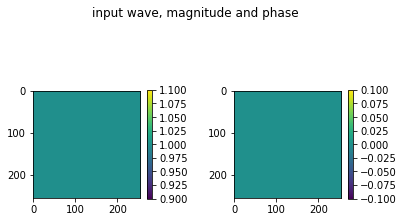

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(np.abs(wave))
fig.colorbar(im1, ax=ax1,shrink=0.5)
im2 = ax2.imshow(unwrap_phase(np.angle(wave)))
fig.colorbar(im2, ax=ax2,shrink=0.5)
fig.suptitle('input wave, magnitude and phase')
fig.subplots_adjust(wspace=0.5)
plt.show()

In [9]:
def step_1(wave_new,wave,B,dim_z,r_y,r_z,k):
    c = ((Δx/4)*F[i,1:-1,k])
    d = wave[1:-1,k]*(1+c) + (r_z/2)*(wave[1:-1,k-1]-2*wave[1:-1,k]+wave[1:-1,k+1])
    d[0]  += (r_y/2)*wave[0,k]
    d[-1] += (r_y/2)*wave[-1,k]
    B = B - diags(c,offsets=0)
    wave_new[1:-1,k] = splinalg.spsolve(B,d)

def step_2(wave_new,wave,B,dim_y,r_y,r_z,j):
    c = ((Δx/4)*F[i,j,1:-1])
    d = wave[j,1:-1]*(1+c) + (r_y/2)*(wave[j-1,1:-1]-2*wave[j,1:-1]+wave[j+1,1:-1])
    d[0]  += (r_z/2)*wave[j,0]
    d[-1] += (r_z/2)*wave[j,-1]
    B = B - diags(c,offsets=0)
    wave_new[j,1:-1] = splinalg.spsolve(B,d)

In [10]:
for i in trange(dim_x):
    b_diag = np.ones(dim_z-2)*(1 + r_y)
    B = diags(b_diag,offsets=0) + diags(-r_y/2*np.ones(dim_z-3),offsets=1) + diags(-r_y/2*np.ones(dim_z-3),offsets=-1)
    for k in range(1,dim_z-1):
        step_1(wave_new,wave,B,dim_z,r_y,r_z,k)

    b_diag = np.ones(dim_y-2)*(1 + r_z)
    B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_y-3),offsets=1) + diags(-r_z/2*np.ones(dim_y-3),offsets=-1) 
    for j in range(1,dim_y-1):
        step_2(wave,wave_new,B,dim_y,r_y,r_z,j)
    
    wave_history[i,1:-1,1:-1] = wave[1:-1,1:-1]

100%|██████████| 255/255 [02:48<00:00,  1.52it/s]


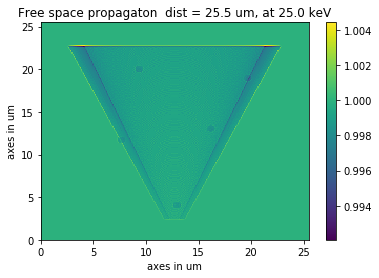

In [11]:
plt.imshow((np.abs(wave_history[-1,:,:])),origin='lower',extent=coords,aspect='auto')
plt.colorbar()
plt.xlabel('axes in um')
plt.ylabel('axes in um')
plt.title('Free space propagaton  dist = '+str(round(x[-1]*1e6,3))+' um, at '+str(round(E*1e-3,3))+' keV')
plt.show()

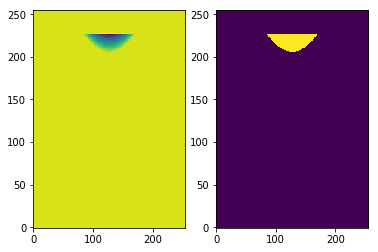

In [12]:
i = 35
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow((np.abs(wave_history[i,:,:])),origin='lower',aspect='auto')
ax2.imshow((np.abs(grid_delta[:,:,i])),origin='lower',aspect='auto')
plt.show()

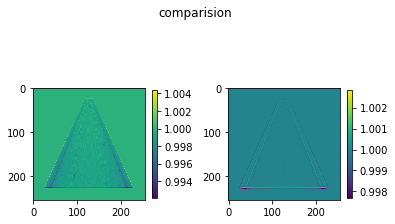

In [18]:
ming_out = np.load('ming_output.npy')

fig,(ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(np.abs(wave_history[-1,:,:]))
fig.colorbar(im1, ax=ax1,shrink=0.5)
im2 = ax2.imshow(np.abs(ming_out))
fig.colorbar(im2, ax=ax2,shrink=0.5)
fig.suptitle('comparision')
fig.subplots_adjust(wspace=0.4)
plt.show()